In [1]:
%pylab inline
#%load_ext autoreload
#%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, '..')
import tensorflow as tf
import tf_slim as slim
from graphgan.utils import get_3d_direction
from graphgan.layers import *
from graphgan.gradient_penalty import gradient_penaly
from graphgan.datasets import graph_input_fn
from astropy.table import Table, join
from functools import partial
from halotools_ia.correlation_functions  import ed_3d,ee_3d, ed_3d_one_two_halo_decomp
print(" Available: ",  (tf.config.list_physical_devices('GPU')))
from sklearn.preprocessing import RobustScaler


Populating the interactive namespace from numpy and matplotlib



 Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import pickle
from pandas import *
mb2 = Table.read('/hildafs/home/yjagvara/graphs4ia/MB2_subfind_z_1.0_small.hdf5' )
mb2 = mb2[log10(mb2['halos.m_star']*10**10)>9]
tng = pickle.load(  open('/hildafs/projects/phy200017p/yjagvara/some_data/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl', "rb" ) )

#tng = Table.from_pandas(DataFrame(tng))
tng = tng[tng['dm_mass']>0]
tng = tng[[log10(tng['dm_mass']*10**10)>9]]
tng = tng[[log10(tng['mass']*10**10)>9]]

/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/astropy/table/table.py:1145: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

In [7]:
from sklearn.preprocessing import RobustScaler

# Reoriente all galaxies with respect to the tidal field
# Pre-processing the orientation of galaxies with respect to their host haloes and the tidal field

# Computes the size of groups
gids, idx, inv, counts  = np.unique(mb2['groups.groupId'],  return_index=True, return_inverse=True, return_counts=True)
mb2['group_size'] = counts[inv]

# Convert distances to Mpc
mb2['halos.x'] /= 1000.
mb2['halos.y'] /= 1000.
mb2['halos.z'] /= 1000.

mb2['groups.x'] /= 1000.
mb2['groups.y'] /= 1000.
mb2['groups.z'] /= 1000.

# Computes direction to the central
mb2['cen_x'] = mb2['groups.x'][idx][inv] - mb2['halos.x']
mb2['cen_y'] = mb2['groups.y'][idx][inv] - mb2['halos.y']
mb2['cen_z'] = mb2['groups.z'][idx][inv] - mb2['halos.z']
ncen = np.sqrt(mb2['cen_x']**2 + mb2['cen_y']**2 + mb2['cen_z']**2 ) 
mb2['cen_r'] = ncen

inds_cent = ncen == 0
ncen[ncen == 0] = 1
mb2['cen_x'] = mb2['cen_x']/ncen
mb2['cen_y'] = mb2['cen_y']/ncen
mb2['cen_z'] = mb2['cen_z']/ncen

# # First reorienting the tidal 
# a = (mb2['tid1000.c_x']*mb2['cen_x'] +
#      mb2['tid1000.c_y']*mb2['cen_y'] +
#      mb2['tid1000.c_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0
# mb2['tid1000.c_x'] *= flip_a
# mb2['tid1000.c_y'] *= flip_a
# mb2['tid1000.c_z'] *= flip_a
# mb2['tid1000.b_x'] *= flip_a
# mb2['tid1000.b_y'] *= flip_a
# mb2['tid1000.b_z'] *= flip_a

# Computing angle with respect to the tidal field,
# adjusting the axes to have the same orientation
aTid = (mb2['shapesDM.a3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.a3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.a3d_z']*mb2['tid1000.c_z'])
bTid = (mb2['shapesDM.b3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.b3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.b3d_z']*mb2['tid1000.c_z'])
cTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.c3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.c3d_z']*mb2['tid1000.c_z'])
caTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.a_x'] +
         mb2['shapesDM.c3d_y']*mb2['tid1000.a_y'] +
         mb2['shapesDM.c3d_z']*mb2['tid1000.a_z'])

# According to the sign, decide to reverse the orientation of
# the dark matter halo by rotating around b or c
flip_a = ones_like(aTid)
flip_a[where(aTid < 0)] *= -1.0
flip_c = ones_like(cTid)
flip_c[where(caTid < 0)] *= -1.0
flip_b = ones_like(bTid)
flip_b = flip_a * flip_c

# Apply rotation around c, thus preserving the sign of c
aTid *= flip_a
bTid *= flip_b
cTid *= flip_c

# Update the DM halo orientation
mb2['shapesDM.a3d_x'] *= flip_a
mb2['shapesDM.a3d_y'] *= flip_a
mb2['shapesDM.a3d_z'] *= flip_a
mb2['shapesDM.b3d_x'] *= flip_b
mb2['shapesDM.b3d_y'] *= flip_b
mb2['shapesDM.b3d_z'] *= flip_b
mb2['shapesDM.c3d_x'] *= flip_c
mb2['shapesDM.c3d_y'] *= flip_c
mb2['shapesDM.c3d_z'] *= flip_c

# Compute misalignment of stellar component in same rotated frame
a = (mb2['shapesDM.a3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.a3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.a3d_z']*mb2['shapesStar.a3d_z'])
b = (mb2['shapesDM.b3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.b3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.b3d_z']*mb2['shapesStar.a3d_z'])
c = (mb2['shapesDM.c3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.c3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.c3d_z']*mb2['shapesStar.a3d_z'])
cc = (mb2['shapesDM.c3d_x']*mb2['shapesStar.c3d_x'] +
      mb2['shapesDM.c3d_y']*mb2['shapesStar.c3d_y'] +
      mb2['shapesDM.c3d_z']*mb2['shapesStar.c3d_z'])

# Apply rotation to the Stellar shape frame to match DM frame
flip_a_stel = ones_like(a)
flip_a_stel[where(a < 0)] *= -1.0
flip_c_stel = ones_like(cc)
flip_c_stel[where(cc < 0)] *= -1.0
flip_b_stel = flip_a_stel * flip_c_stel

# Rotation around c, leaving c unchanged
# Rotation around a, leaving a unchanged
a *= flip_a_stel
b *= flip_b_stel
c *= flip_c_stel

# Update the Stellar halo orientation
mb2['shapesStar.a3d_x'] *= flip_a_stel
mb2['shapesStar.a3d_y'] *= flip_a_stel
mb2['shapesStar.a3d_z'] *= flip_a_stel
mb2['shapesStar.b3d_x'] *= flip_b_stel
mb2['shapesStar.b3d_y'] *= flip_b_stel
mb2['shapesStar.b3d_z'] *= flip_b_stel
mb2['shapesStar.c3d_x'] *= flip_c_stel
mb2['shapesStar.c3d_y'] *= flip_c_stel
mb2['shapesStar.c3d_z'] *= flip_c_stel

# For the centrals, let's use the direction of the dark matter halo, why not
# mb2['cen_x'][inds_cent] = mb2['shapesDM.a3d_x'][inds_cent]
# mb2['cen_y'][inds_cent] = mb2['shapesDM.a3d_y'][inds_cent]
# mb2['cen_z'][inds_cent] = mb2['shapesDM.a3d_z'][inds_cent]

# Make the orientation of the central directoin match the DM orientation
# a = (mb2['shapesDM.a3d_x']*mb2['cen_x'] +
#      mb2['shapesDM.a3d_y']*mb2['cen_y'] +
#      mb2['shapesDM.a3d_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0

# mb2['shapesDM.a3d_x'] *= flip_a
# mb2['shapesDM.a3d_y'] *= flip_a
# mb2['shapesDM.a3d_z'] *= flip_a

# Doing some preprocessing
mb2['halos.mass'] = log10(mb2['halos.mass'])
mb2['groups.mass'] = log10(mb2['groups.mass']*1e10+1)
mb2['halos.m_star'] = log10(mb2['halos.m_star']*1e10+1)
mb2['halos.m_dm'] = log10(mb2['halos.m_dm']*1e10+1)
m = (mb2['halos.m_star'] > 8.5) & (mb2['halos.mass'] > 10) & (mb2['group_size'] > 1)& (mb2['group_size'] < 500)
mb2_cat=mb2[m]

In [11]:
mb2_cat

halos.subfindId,halos.central,halos.mass,halos.vdisp,halos.vcirc,halos.rcirc,halos.m_gas,halos.m_dm,halos.m_star,halos.m_bh,halos.x,halos.y,halos.z,halos.vx,halos.vy,halos.vz,groups.groupId,groups.subfindId,groups.mass,groups.m_gas,groups.m_dm,groups.m_star,groups.m_bh,groups.x,groups.y,groups.z,groups.vx,groups.vy,groups.vz,prop.sfr,prop.btr,prop.SDSS_g,prop.SDSS_i,prop.SDSS_r,prop.SDSS_u,prop.SDSS_z,shapesDM.q3d,shapesDM.s3d,shapesDM.q2d,shapesDM.a3d_x,shapesDM.a3d_y,shapesDM.a3d_z,shapesDM.b3d_x,shapesDM.b3d_y,shapesDM.b3d_z,shapesDM.c3d_x,shapesDM.c3d_y,shapesDM.c3d_z,shapesDM.a2d_x,shapesDM.a2d_y,shapesDM.b2d_x,shapesDM.b2d_y,shapesStar.q3d,shapesStar.s3d,shapesStar.q2d,shapesStar.a3d_x,shapesStar.a3d_y,shapesStar.a3d_z,shapesStar.b3d_x,shapesStar.b3d_y,shapesStar.b3d_z,shapesStar.c3d_x,shapesStar.c3d_y,shapesStar.c3d_z,shapesStar.a2d_x,shapesStar.a2d_y,shapesStar.b2d_x,shapesStar.b2d_y,tid500.a_x,tid500.a_y,tid500.a_z,tid500.b_x,tid500.b_y,tid500.b_z,tid500.c_x,tid500.c_y,tid500.c_z,tid500.eigv1,tid500.eigv2,tid500.eigv3,tid1000.a_x,tid1000.a_y,tid1000.a_z,tid1000.b_x,tid1000.b_y,tid1000.b_z,tid1000.c_x,tid1000.c_y,tid1000.c_z,tid1000.eigv1,tid1000.eigv2,tid1000.eigv3,tid10000.a_x,tid10000.a_y,tid10000.a_z,tid10000.b_x,tid10000.b_y,tid10000.b_z,tid10000.c_x,tid10000.c_y,tid10000.c_z,tid10000.eigv1,tid10000.eigv2,tid10000.eigv3,group_size,cen_x,cen_y,cen_z,cen_r
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
6800000000.0,1.0,14.152074202768228,760.798,1226.83,196.411,1841.23,14.080969026019089,12.479573870681591,0.647951,49.780199999999994,38.698699999999995,54.185300000000005,-77.1477,23.483,261.713,0.0,6800000000.0,14.207645137112388,1880.77,13744.8,504.102,0.735809,49.718599999999995,38.7296,54.192,-33.5259,22.3453,131.134,381.086,0.0,831.319,1247.7,1127.65,401.702,1437.19,0.665701,0.509238,0.728018,0.90176,-0.0732794,-0.425981,0.168034,0.967437,0.189288,0.398239,-0.242272,0.884709,0.998796,-0.0490639,0.0490639,0.998796,0.754858,0.479079,0.821757,0.86875,-0.264746,-0.418549,-0.309392,-0.950039,-0.0412514,0.386717,-0.165333,0.907257,0.957996,-0.286783,0.286783,0.957996,0.398901,-0.194755,0.896074,0.167241,0.976248,0.13773,0.901614,-0.0949198,-0.421998,10244.6,9640.07,8091.62,0.399539,0.0674366,0.914232,0.137383,0.981623,-0.132447,0.906363,-0.178517,-0.382932,2101.99,1984.24,1522.56,-0.162228,-0.854975,-0.492645,0.151396,-0.514914,0.843767,0.97507,-0.0622978,-0.212974,19.468,12.9233,5.19113,238,-0.8896515111403409,0.44626999503635534,0.09676404423110414,0.06924059502921617
6800000001.0,0.0,11.851641704318869,270.777,497.473,2.08682,0.0,11.72911941327278,11.24164358834711,0.0244049,49.9552,38.6441,54.0375,1876.47,634.05,180.576,0.0,6800000000.0,14.207645137112388,1880.77,13744.8,504.102,0.735809,49.718599999999995,38.7296,54.192,-33.5259,22.3453,131.134,0.0,0.0,17.9133,42.0612,32.5896,4.99177,52.3488,0.891883,0.774532,0.883721,0.030342,-0.36233,-0.931556,0.876871,-0.437693,0.198802,-0.479767,-0.822887,0.304436,0.818609,-0.574351,0.574351,0.818609,0.930907,0.517748,0.642966,0.0959225,-0.537802,-0.837596,-0.713594,0.549503,-0.434545,-0.693961,-0.639387,0.331063,0.654302,-0.756233,-0.756233,-0.654302,0.39716,-0.357643

In [13]:
catalog = mb2_cat
catalog['dm_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['halos.m_dm'].reshape((-1,1))),-5,5).squeeze()
catalog['mass_scaled'] = clip(RobustScaler().fit_transform(catalog['halos.m_star'].reshape((-1,1))),-5,5).squeeze()
catalog['group_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['groups.mass'].reshape((-1,1))),-5,5).squeeze()

In [5]:
catalog['dm_a'] = log10(catalog['dm_a']*10000)
catalog['dm_b'] = log10(catalog['dm_b']*10000)
catalog['dm_c'] = log10(catalog['dm_c']*10000)

In [18]:
catalog['tid_a_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_0.1_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_0.1_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_0.1_1024'].reshape((-1,1))),-5,5).squeeze()

catalog['tid_a_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_0.5_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_0.5_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_0.5_1024'].reshape((-1,1))),-5,5).squeeze()

catalog['tid_a_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_1.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_1.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_1.0_1024'].reshape((-1,1))),-5,5).squeeze()

catalog['tid_a_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_2.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_2.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_2.0_1024'].reshape((-1,1))),-5,5).squeeze()

In [19]:
weighting='exp'
directions = get_3d_direction()
filter_size=directions.shape[-1]

# Define generator function
def conditional_generator_fn(inputs, 
                             is_training=True,
                             reuse=None,
                             scope='Generator',
                             fused_batch_norm=False):

    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = inputs
    # W_i matrices define the sprase matrix to construct adjecency
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    # Computes 3D adjacency matrix
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, radial_scale=0.4,
                           learn_scale=False)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=64,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    
    # Let's constrain the output to lie on the sphere, predicting major axis of the galaxy (unit vector)
    net_a3d = graph_conv2(net, mr, 3, activation_fn=tf.nn.relu, one_hop=False)
    #net_a3d = tf.nn.l2_normalize(net_a3d, axis=-1)
    
    # Assemble output, 
    out_net = tf.concat([net_a3d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = conditioning
    #pm_i are the pooling matrices, also sparse
    
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    pool = tf.SparseTensor(tf.cast(pm0, tf.int64), pm1, pm2)
    
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, learn_scale=False, 
                           radial_scale=0.2)

    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling, MeanPooling
    net = tf.compat.v1.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)
    
    return net

In [25]:
import tensorflow_gan as tfgan
from tensorflow_gan.python import namedtuples

my_config = tf.estimator.RunConfig(
    save_summary_steps = 500,
    save_checkpoints_steps = 5000,
    keep_checkpoint_max = 500,       # Retain the 10 most recent checkpoints.
)
#tensorboard
def silly_custom_discriminator_loss(gan_model,reduction='', add_summaries=True):
    return tf.reduce_mean(gan_model.discriminator_real_outputs**2)

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                  10.*gradient_penaly(*args, **kwargs)+
                                                   0.001*silly_custom_discriminator_loss(*args, **kwargs)),   
    generator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(train_steps=namedtuples.GANTrainSteps(3, 1)),
    model_dir='./scale_multi_Nmesh_1024_MLP-1_only_cent', 
    config=my_config)
#hooks specify how the two networks are trained each step or iteration

INFO:tensorflow:Using config: {'_model_dir': './scale_multi_Nmesh_1024_MLP-1_only_cent', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 500, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [44]:
training_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled', 
                                    'tid_a_0.1_1024_scaled', 'tid_b_0.1_1024_scaled', 'tid_c_0.1_1024_scaled',
                                       'tid_a_0.5_1024_scaled', 'tid_b_0.5_1024_scaled', 'tid_c_0.5_1024_scaled',
                                       'tid_a_1.0_1024_scaled', 'tid_b_1.0_1024_scaled', 'tid_c_1.0_1024_scaled',
                                       'tid_a_2.0_1024_scaled', 'tid_b_2.0_1024_scaled', 'tid_c_2.0_1024_scaled'), 

                      
                      scalar_labels=('dm_a', 'dm_b', 'dm_c'),
                      shuffle=True, rotate=True, repeat=True, noise_size=32, batch_size=64)

testing_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled' ,
                                      'tid_a_0.1_1024_scaled', 'tid_b_0.1_1024_scaled', 'tid_c_0.1_1024_scaled',
                                       'tid_a_0.5_1024_scaled', 'tid_b_0.5_1024_scaled', 'tid_c_0.5_1024_scaled',
                                       'tid_a_1.0_1024_scaled', 'tid_b_1.0_1024_scaled', 'tid_c_1.0_1024_scaled',
                                       'tid_a_2.0_1024_scaled', 'tid_b_2.0_1024_scaled', 'tid_c_2.0_1024_scaled'),#,'tid_a_scaled','tid_b_scaled','tid_c_scaled'),

                      scalar_labels=('dm_a', 'dm_b', 'dm_c'),
                      shuffle=False, rotate=False, repeat=False, noise_size=32, batch_size=64)
#Separately providng vector and scalar features, so as to take of of things such as rotation

#just do this on centrals , remove all of the satellites. 
#try adding tid eigenvalues

In [60]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gan_estimator.train(training_fn, steps=50000)

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80000...
INFO:tensorflow:Saving checkpoints for 80000 into ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80000...
INFO:tensorflow:loss = 0.3590333, step = 80000
INFO:tensorflow:global_step/sec: 3.86245
INFO:tensorflow:loss = 0.29314342, step = 80101 (25.891 sec)
INFO:tensorflow:global_step/sec: 4.31486
INFO:tensorflow:loss = 0.34995136, step = 80201 (23.176 sec)
INFO:tensorflow:global_step/sec: 4.36856
INFO:tensorflow:loss = 0.3527683, step = 80301 (22.891 sec)
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.26783413, step = 87101 (22.964 sec)
INFO:tensorflow:global_step/sec: 4.50309
INFO:tensorflow:loss = 0.34399396, step = 87201 (22.207 sec)
INFO:tensorflow:global_step/sec: 4.30799
INFO:tensorflow:loss = 0.15214014, step = 87301 (23.213 sec)
INFO:tensorflow:global_step/sec: 4.3993
INFO:tensorflow:loss = 0.20798677, step = 87401 (22.731 sec)
INFO:tensorflow:global_step/sec: 4.29777
INFO:tensorflow:loss = 0.24607849, step = 87501 (23.268 sec)
INFO:tensorflow:global_step/sec: 4.35183
INFO:tensorflow:loss = 0.36426118, step = 87601 (22.979 sec)
INFO:tensorflow:global_step/sec: 4.44123
INFO:tensorflow:loss = 0.35289785, step = 87701 (22.517 sec)
INFO:tensorflow:global_step/sec: 4.26475
INFO:tensorflow:loss = 0.37308413, step = 87801 (23.448 sec)
INFO:tensorflow:global_step/sec: 4.40911
INFO:tensorflow:loss = 0.12890387, step = 87901 (22.680 sec)
INFO:tensorflow:global_step/sec: 4.41062
INFO:tensorflow:loss = 0.14031889, step = 88001 (22.673 sec)
INFO:tensorflow:global

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95000...
INFO:tensorflow:Saving checkpoints for 95000 into ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95000...
INFO:tensorflow:global_step/sec: 4.03132
INFO:tensorflow:loss = 0.6292669, step = 95001 (24.806 sec)
INFO:tensorflow:global_step/sec: 4.42673
INFO:tensorflow:loss = 0.26136214, step = 95101 (22.590 sec)
INFO:tensorflow:global_step/sec: 4.37338
INFO:tensorflow:loss = 0.37099296, step = 95201 (22.866 sec)
INFO:tensorflow:global_step/sec: 4.47856
INFO:tensorflow:loss = 0.24204868, step = 95301 (22.328 sec)
INFO:tensorflow:global_step/sec: 4.37819
INFO:tensorflow:loss = 0.20996733, step = 95401 (22.841 sec)
INFO:tensorflow:global_step/sec: 4.4544
INFO:tensorflow:loss = 0.2842642, step = 95501 (22.449 sec)
INFO:tensorflow:global_step/sec: 4.32169
INFO:tensorflow:loss = 0.33686438, step = 95601 (23.139 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.2540447, step = 102501 (23.009 sec)
INFO:tensorflow:global_step/sec: 4.42032
INFO:tensorflow:loss = 0.13839538, step = 102601 (22.622 sec)
INFO:tensorflow:global_step/sec: 4.28011
INFO:tensorflow:loss = 0.32435778, step = 102701 (23.364 sec)
INFO:tensorflow:global_step/sec: 4.26445
INFO:tensorflow:loss = 1.0139627, step = 102801 (23.450 sec)
INFO:tensorflow:global_step/sec: 4.38334
INFO:tensorflow:loss = 0.24604817, step = 102901 (22.814 sec)
INFO:tensorflow:global_step/sec: 4.22476
INFO:tensorflow:loss = 0.33545938, step = 103001 (23.670 sec)
INFO:tensorflow:global_step/sec: 4.32934
INFO:tensorflow:loss = 0.23081519, step = 103101 (23.098 sec)
INFO:tensorflow:global_step/sec: 4.33748
INFO:tensorflow:loss = 0.307066, step = 103201 (23.055 sec)
INFO:tensorflow:global_step/sec: 4.40354
INFO:tensorflow:loss = 0.20032683, step = 103301 (22.709 sec)
INFO:tensorflow:global_step/sec: 4.38652
INFO:tensorflow:loss = 0.23746854, step = 103401 (22.797 sec)
INFO:tensorflow

INFO:tensorflow:loss = 0.30818376, step = 110001 (24.180 sec)
INFO:tensorflow:global_step/sec: 4.4028
INFO:tensorflow:loss = 0.2818439, step = 110101 (22.713 sec)
INFO:tensorflow:global_step/sec: 4.35834
INFO:tensorflow:loss = 0.23739158, step = 110201 (22.945 sec)
INFO:tensorflow:global_step/sec: 4.229
INFO:tensorflow:loss = 0.3414801, step = 110301 (23.647 sec)
INFO:tensorflow:global_step/sec: 4.52263
INFO:tensorflow:loss = 0.3243482, step = 110401 (22.110 sec)
INFO:tensorflow:global_step/sec: 4.41597
INFO:tensorflow:loss = 0.29961511, step = 110501 (22.645 sec)
INFO:tensorflow:global_step/sec: 4.33259
INFO:tensorflow:loss = 0.17324924, step = 110601 (23.081 sec)
INFO:tensorflow:global_step/sec: 4.39664
INFO:tensorflow:loss = 0.25797966, step = 110701 (22.745 sec)
INFO:tensorflow:global_step/sec: 4.42001
INFO:tensorflow:loss = 0.32940307, step = 110801 (22.625 sec)
INFO:tensorflow:global_step/sec: 4.33887
INFO:tensorflow:loss = 0.3397443, step = 110901 (23.047 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 4.39762
INFO:tensorflow:loss = 0.21692382, step = 117801 (22.739 sec)
INFO:tensorflow:global_step/sec: 4.259
INFO:tensorflow:loss = 0.2799876, step = 117901 (23.480 sec)
INFO:tensorflow:global_step/sec: 4.37015
INFO:tensorflow:loss = 0.25025672, step = 118001 (22.883 sec)
INFO:tensorflow:global_step/sec: 4.46332
INFO:tensorflow:loss = 0.3866407, step = 118101 (22.405 sec)
INFO:tensorflow:global_step/sec: 4.32092
INFO:tensorflow:loss = 0.18136345, step = 118201 (23.143 sec)
INFO:tensorflow:global_step/sec: 4.32244
INFO:tensorflow:loss = 0.39789736, step = 118301 (23.135 sec)
INFO:tensorflow:global_step/sec: 4.3587
INFO:tensorflow:loss = 0.22642751, step = 118401 (22.943 sec)
INFO:tensorflow:global_step/sec: 4.39376
INFO:tensorflow:loss = 0.44778445, step = 118501 (22.759 sec)
INFO:tensorflow:global_step/sec: 4.40944
INFO:tensorflow:loss = 0.32249185, step = 118601 (22.679 sec)
INFO:tensorflow:global_step/sec: 4.45574
INFO:tensorflow:loss = 0.3215493, ste

INFO:tensorflow:global_step/sec: 4.39937
INFO:tensorflow:loss = 0.30312765, step = 125301 (22.731 sec)
INFO:tensorflow:global_step/sec: 4.37658
INFO:tensorflow:loss = 0.8599137, step = 125401 (22.849 sec)
INFO:tensorflow:global_step/sec: 4.27037
INFO:tensorflow:loss = 0.36505115, step = 125501 (23.417 sec)
INFO:tensorflow:global_step/sec: 4.35879
INFO:tensorflow:loss = 0.21123452, step = 125601 (22.942 sec)
INFO:tensorflow:global_step/sec: 4.31857
INFO:tensorflow:loss = 0.21335028, step = 125701 (23.156 sec)
INFO:tensorflow:global_step/sec: 4.44953
INFO:tensorflow:loss = 0.3236711, step = 125801 (22.474 sec)
INFO:tensorflow:global_step/sec: 4.33592
INFO:tensorflow:loss = 0.31420872, step = 125901 (23.063 sec)
INFO:tensorflow:global_step/sec: 4.34085
INFO:tensorflow:loss = 0.2530539, step = 126001 (23.037 sec)
INFO:tensorflow:global_step/sec: 4.46115
INFO:tensorflow:loss = 0.8217249, step = 126101 (22.416 sec)
INFO:tensorflow:global_step/sec: 4.54298
INFO:tensorflow:loss = 0.4167701, st

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Ca

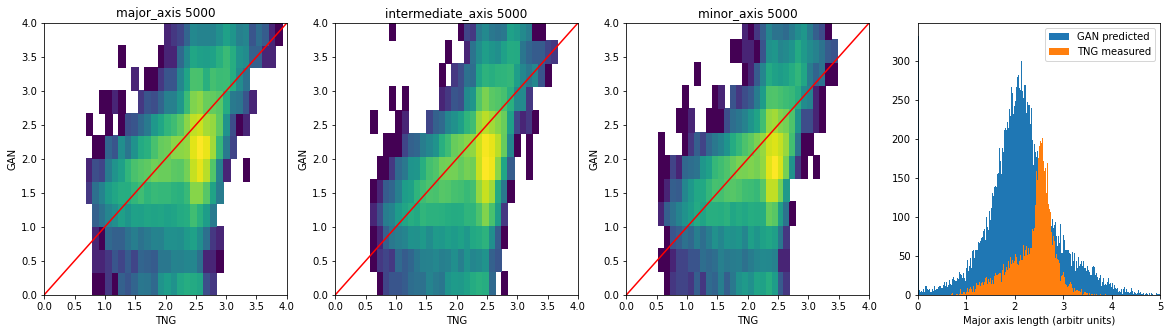

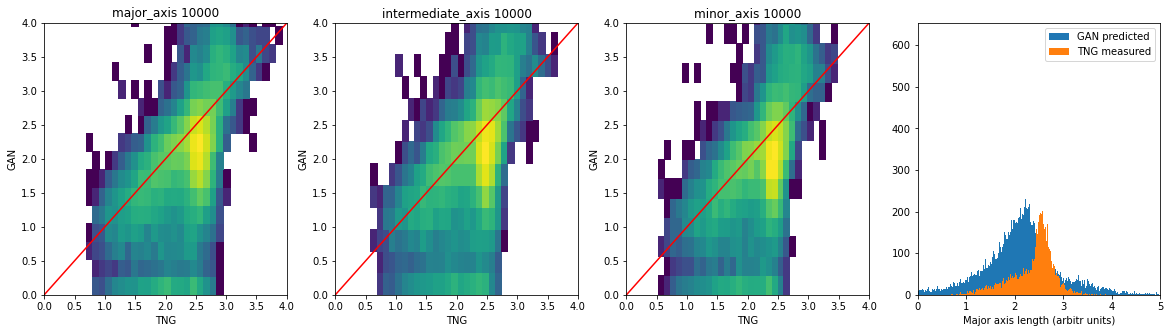

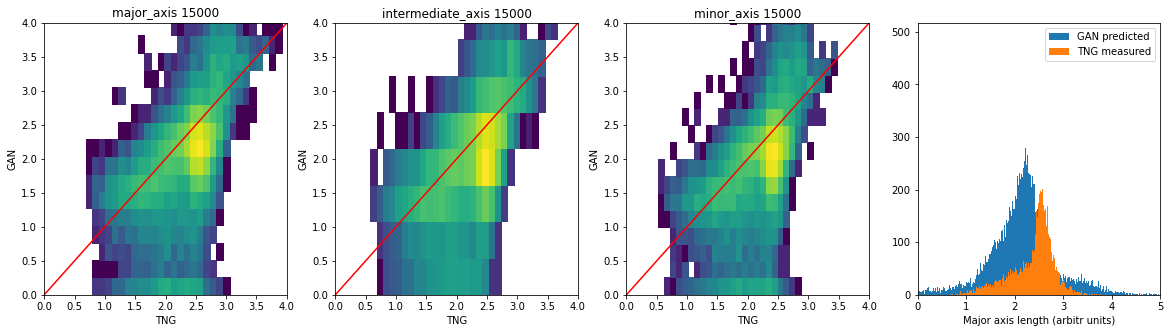

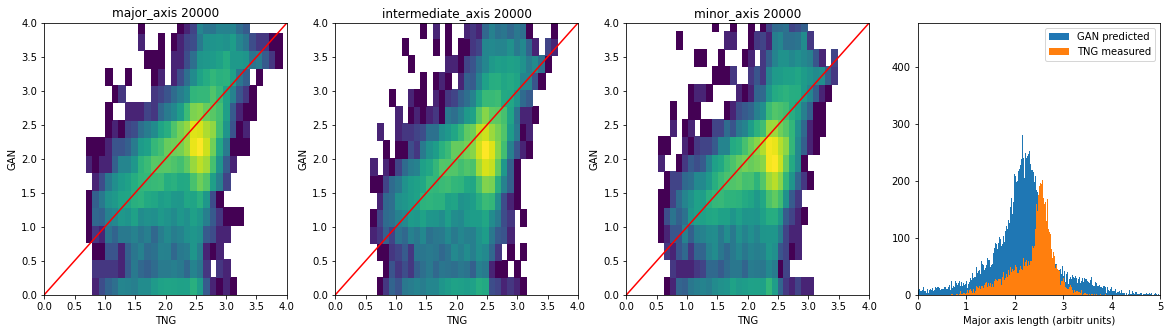

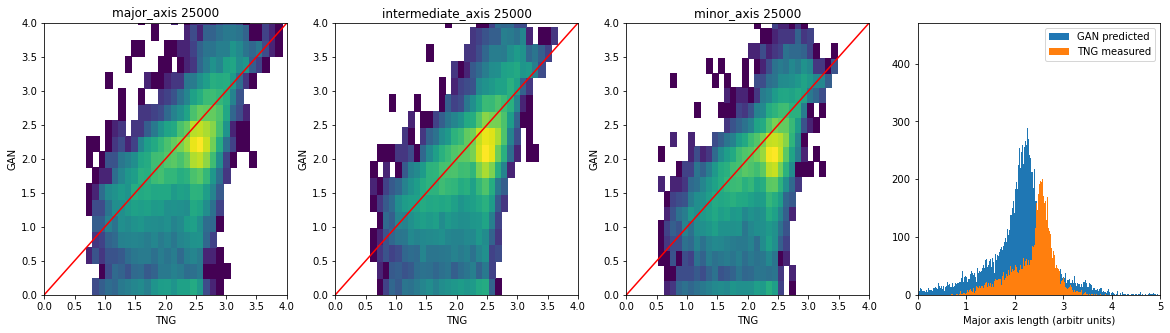

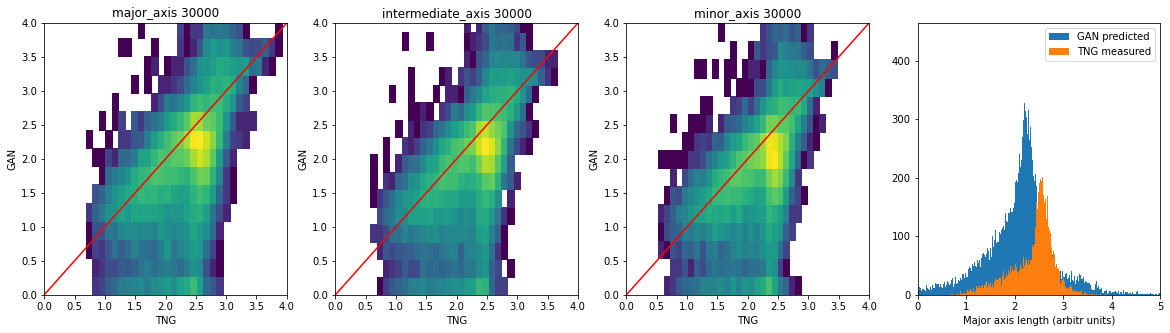

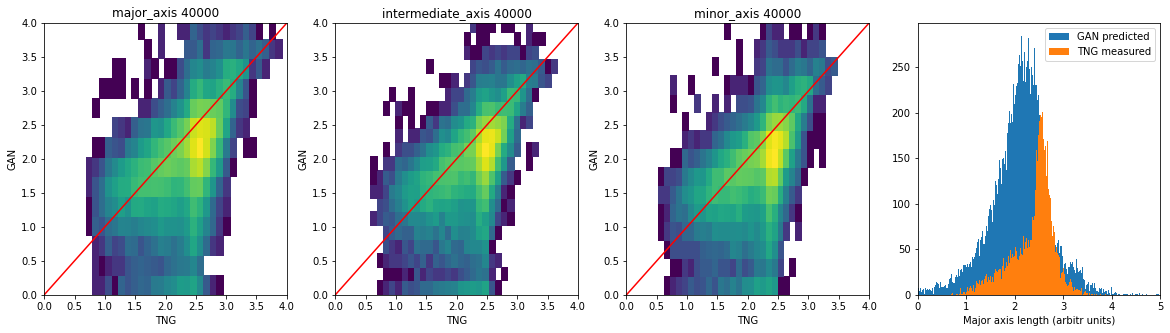

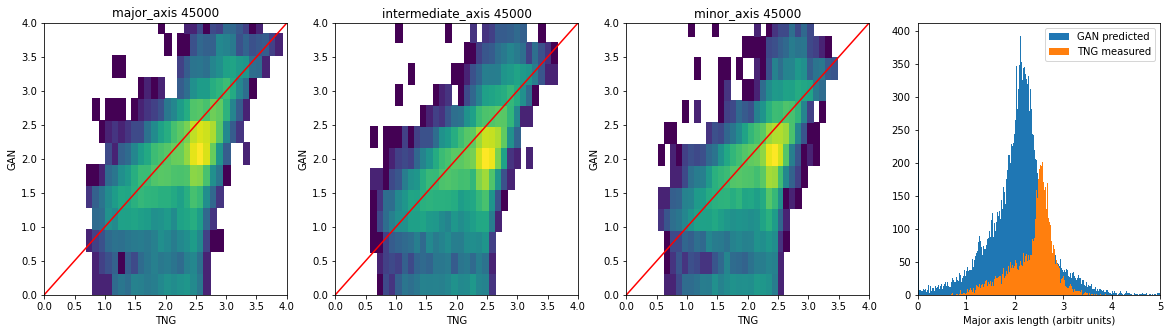

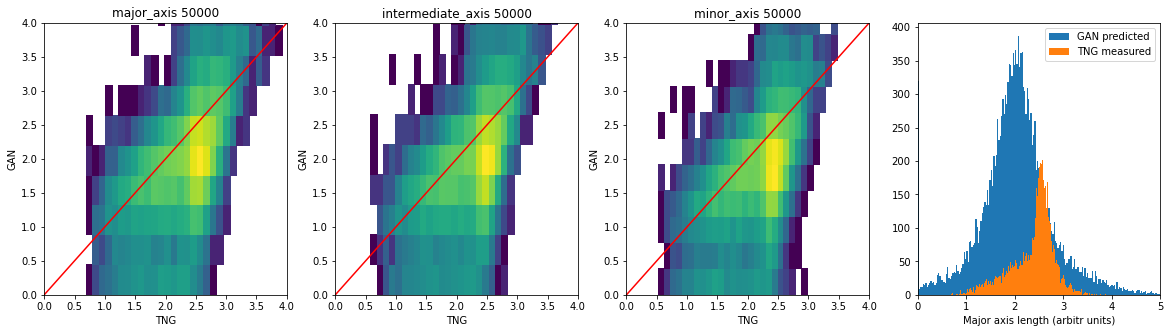

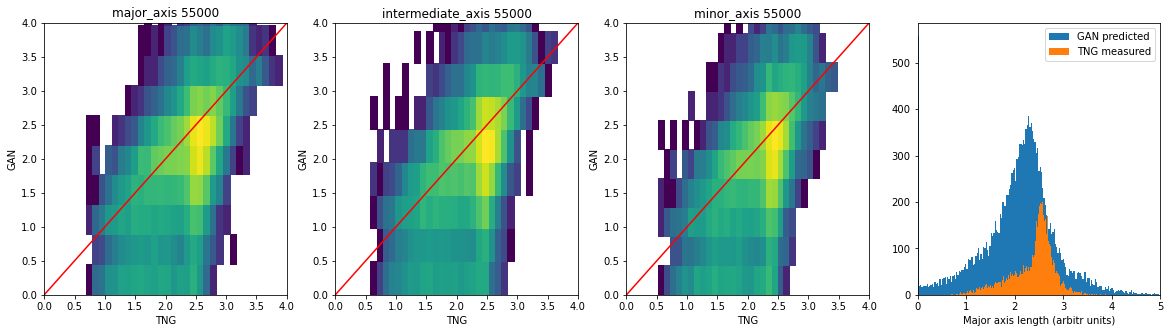

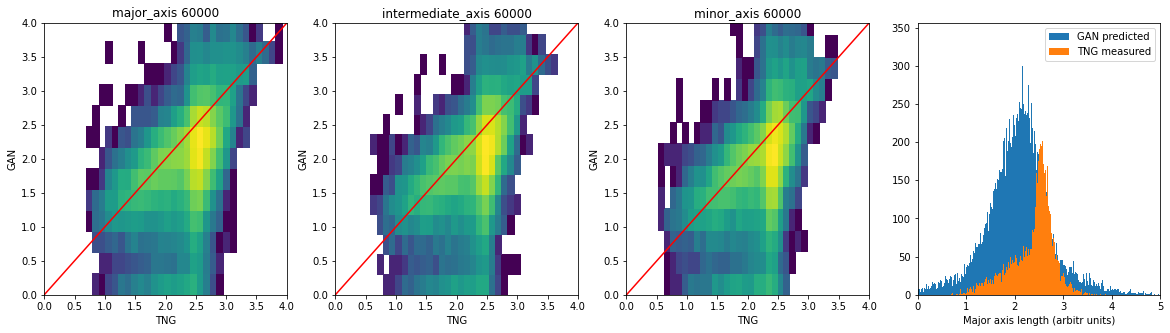

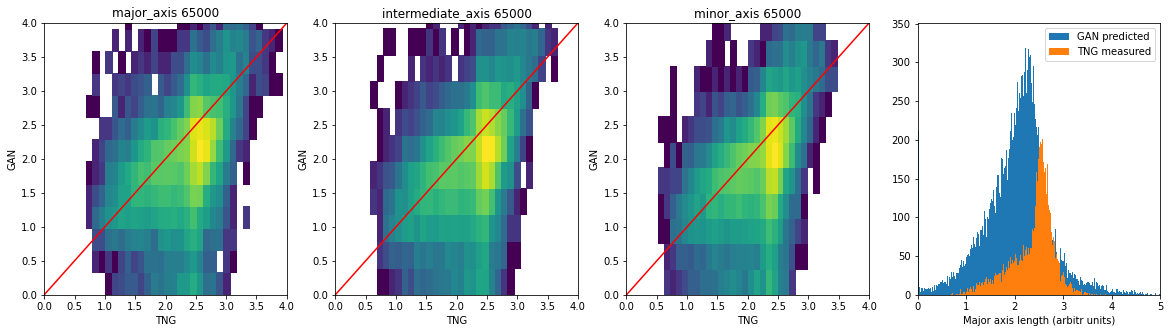

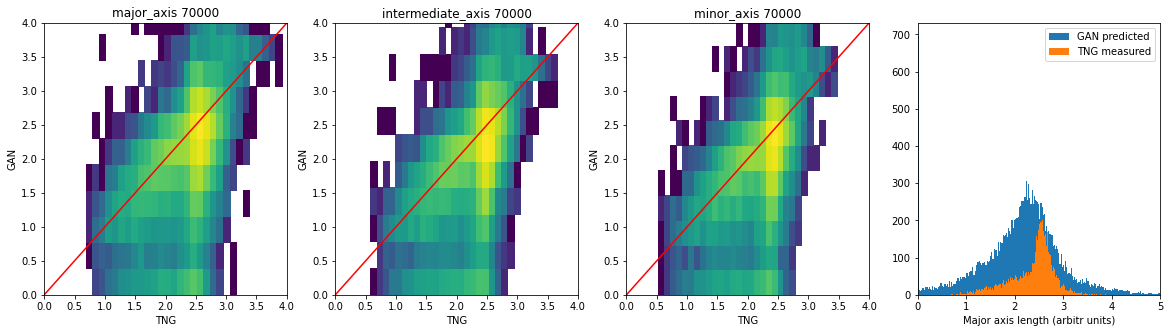

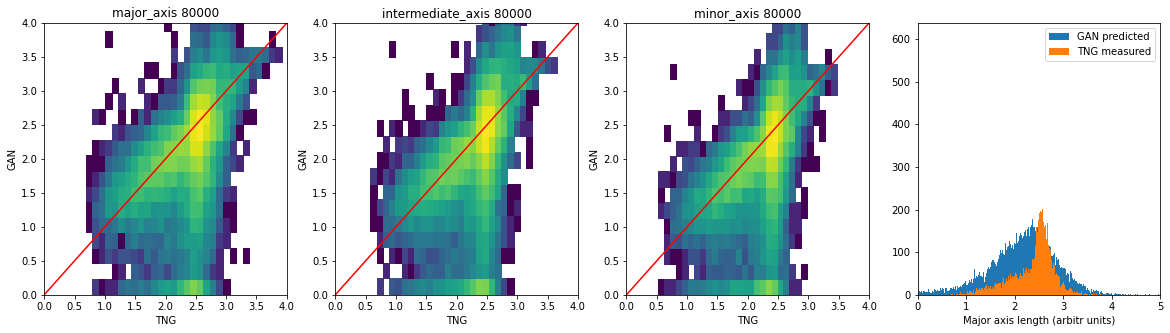

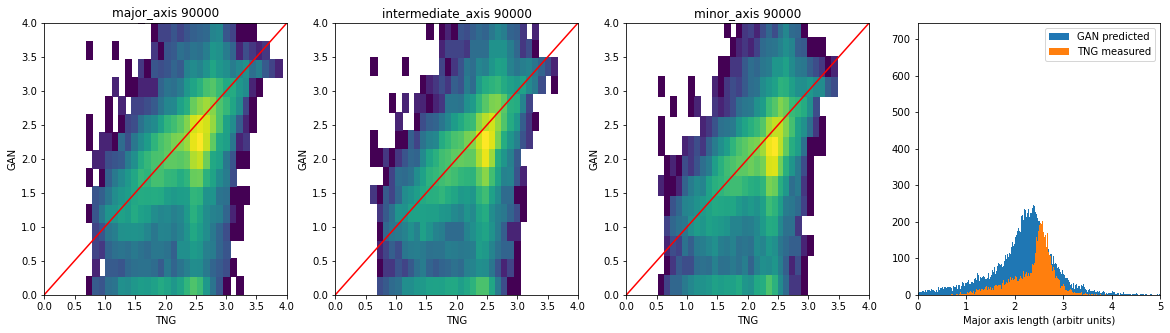

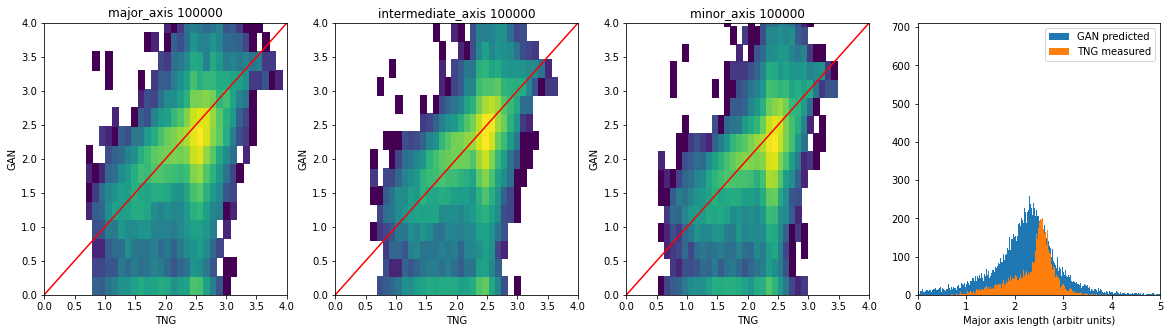

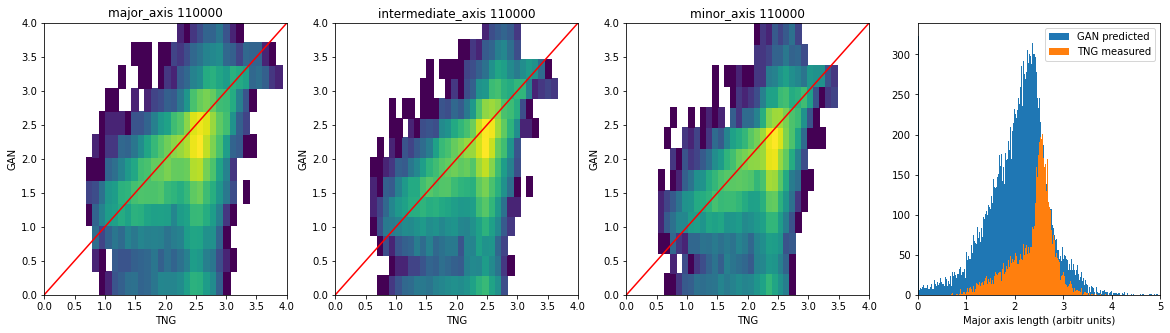

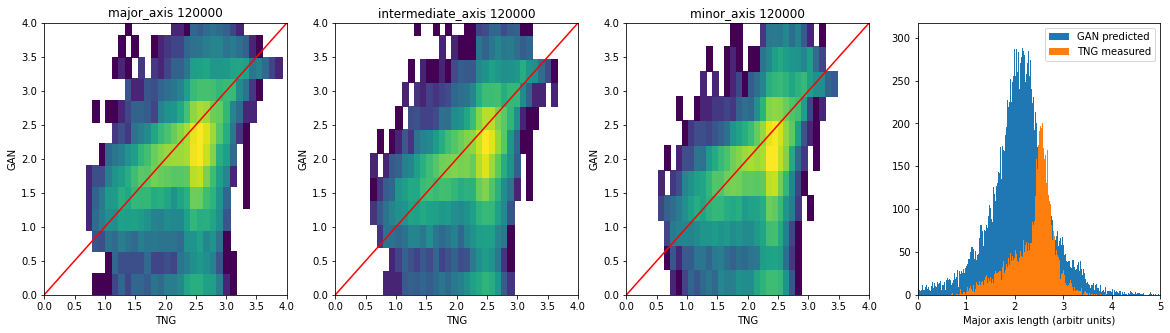

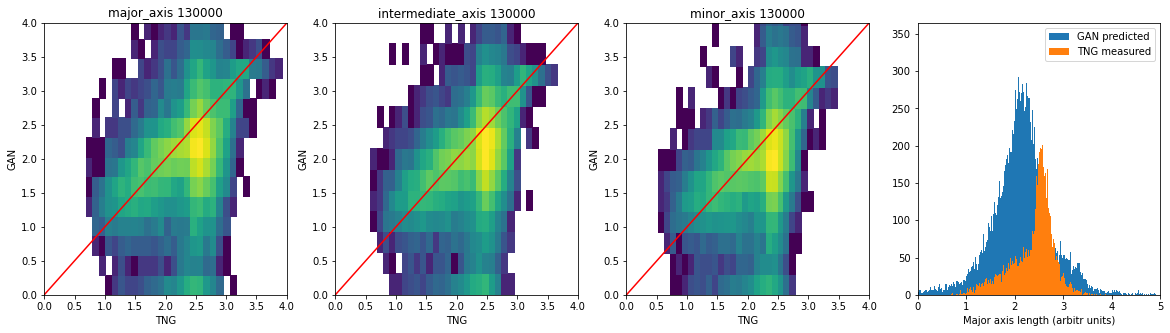

In [61]:
steps=[5000,10000,15000,20000,25000,30000,40000,45000,50000,55000,60000,65000,70000,80000,90000,100000,110000,120000,130000]
for step in steps:    
    gen = gan_estimator.predict(testing_fn, checkpoint_path = './scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-'+str(step) ,yield_single_examples=False)
    #gen = gan_estimator.predict(testing_fn,yield_single_examples=False)
    toto = concatenate([g for g in gen])
    cat = Table(toto, names=['pred_dm_a', 'pred_dm_b', 'pred_dm_c'])
    cat['gal_id'] = catalog['gal_id']
    from astropy.table import join
    res = join(cat,catalog)
 
    tng_axis = np.array([res['dm_a'], res['dm_b'], res['dm_c']]).T 
 
    gan_axis = np.array([res['pred_dm_a'], res['pred_dm_b'], res['pred_dm_c']]).T
 
    # or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    #or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    
    #m = (res['mass'] > 9) & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    bin_num = 30
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    hist2d( tng_axis[:,0],  gan_axis[:,0], bins=bin_num, norm=matplotlib.colors.LogNorm())
    title('major_axis ' +str(step))
    xlim(0,4)
    ylim(0,4)
    xlabel('TNG')
    ylabel('GAN')
    plot([0, 25], [0, 25], c='r')
    plt.subplot(1,4,2)
    hist2d( tng_axis[:,1],  gan_axis[:,1], bins=bin_num, norm=matplotlib.colors.LogNorm())
    title('intermediate_axis ' +str(step))
    xlabel('TNG')
    ylabel('GAN')
    xlim(0,4)
    ylim(0,4)
    plot([0, 25], [0, 25], c='r')
    plt.subplot(1,4,3)
    hist2d( tng_axis[:,2],  gan_axis[:,2], bins=bin_num, norm=matplotlib.colors.LogNorm())
    title('minor_axis ' +str(step))
    xlabel('TNG')
    ylabel('GAN')
    plot([0, 25], [0, 25], c='r')
    xlim(0,4)
    ylim(0,4)
    plt.subplot(1,4,4)
    x=hist(gan_axis[:,0],bins=500,label='GAN predicted')
    x=hist(tng_axis[:,0],bins=500,label='TNG measured')
    xlim(0,5)
    legend()
    xlabel('Major axis length (arbitr units)')
    #try diffreent training epochs
    #try diffrent smoothing scales
    # try by mass bbins to see if the two halo term is affected
    
    
    #plot it just for centrals

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


ValueError: autodetected range of [nan, nan] is not finite

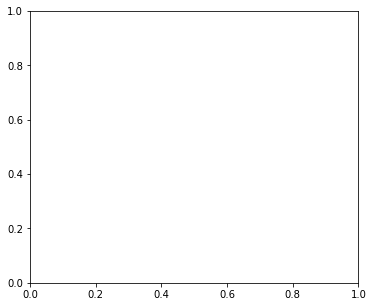

In [37]:
steps=[5000,10000,15000]#,20000,25000]#,30000,40000,45000,50000,55000,60000]#,65000,70000,80000,90000,100000]
for step in steps:    
    gen = gan_estimator.predict(testing_fn, checkpoint_path = './scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt-'+str(step) ,yield_single_examples=False)
    #gen = gan_estimator.predict(testing_fn,yield_single_examples=False)
    toto = concatenate([g for g in gen])
    cat = Table(toto, names=['pred_dm_a', 'pred_dm_b', 'pred_dm_c'])
    cat['gal_id'] = catalog['gal_id']
    from astropy.table import join
    res = join(cat,catalog)
 
    tng_axis = np.array([res['dm_a'], res['dm_b'], res['dm_c']]).T 
 
    gan_axis = np.array([res['pred_dm_a'], res['pred_dm_b'], res['pred_dm_c']]).T
 
    # or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    #or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    
    #m = (res['mass'] > 9) & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    bin_num = 30
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    hist2d( tng_axis[:,1]/tng_axis[:,0],  gan_axis[:,1]/gan_axis[:,0], bins=bin_num, norm=matplotlib.colors.LogNorm())
    title('b/a ' +str(step))
    xlabel('TNG')
    ylabel('GAN')
    plot([0, 25], [0, 25], c='r')
    plt.subplot(1,3,2)
    hist2d( tng_axis[:,2]/tng_axis[:,0],  gan_axis[:,2]/gan_axis[:,0], bins=bin_num, norm=matplotlib.colors.LogNorm())
    title('c/a ' +str(step))
    xlabel('TNG')
    ylabel('GAN')
    plot([0, 25], [0, 25], c='r')
    plt.subplot(1,3,3)
 
   
    #try diffreent training epochs
    #try diffrent smoothing scales
    # try by mass bbins to see if the two halo term is affected
    
    
    #plot it just for centrals

Text(0.5, 0, 'Major axis length (arbitr units)')

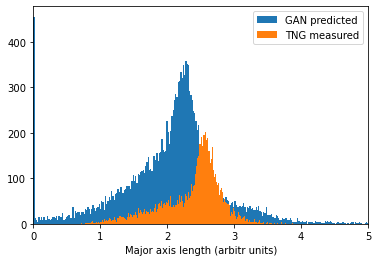

In [56]:
x=hist(gan_axis[:,0],bins=500,label='GAN predicted')
x=hist(tng_axis[:,0],bins=500,label='TNG measured')
xlim(0,5)
legend()
xlabel('Major axis length (arbitr units)')

In [50]:
gan_axis.shape

(17457, 3)

In [51]:
tng_axis.shape

(17457, 3)